In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

os.getcwd()

ModuleNotFoundError: No module named 'seaborn'

# Data pipeline beginning
**Below is a step-by-step follow through of what our model might look like to find subsurface CHLA distributions**

In [3]:
# if saved
dists_to_cluster = pd.read_csv('../data/pivoted_imp_data.csv', index_col=False)
# split data
train_dtc, test_dtc = train_test_split(dists_to_cluster, test_size=0.15, random_state=23)
# Cluster the distributions based on FIRST 25 observations (0-260ft)
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(train_dtc.iloc[:, 10:35])
centers = kmeans.cluster_centers_
train_dtc['cluster'] = clusters

FileNotFoundError: [Errno 2] No such file or directory: '../data/pivoted_imp_data.csv'

**Now we check out the kmeans centers representing our CHLA distributions**

NameError: name 'centers' is not defined

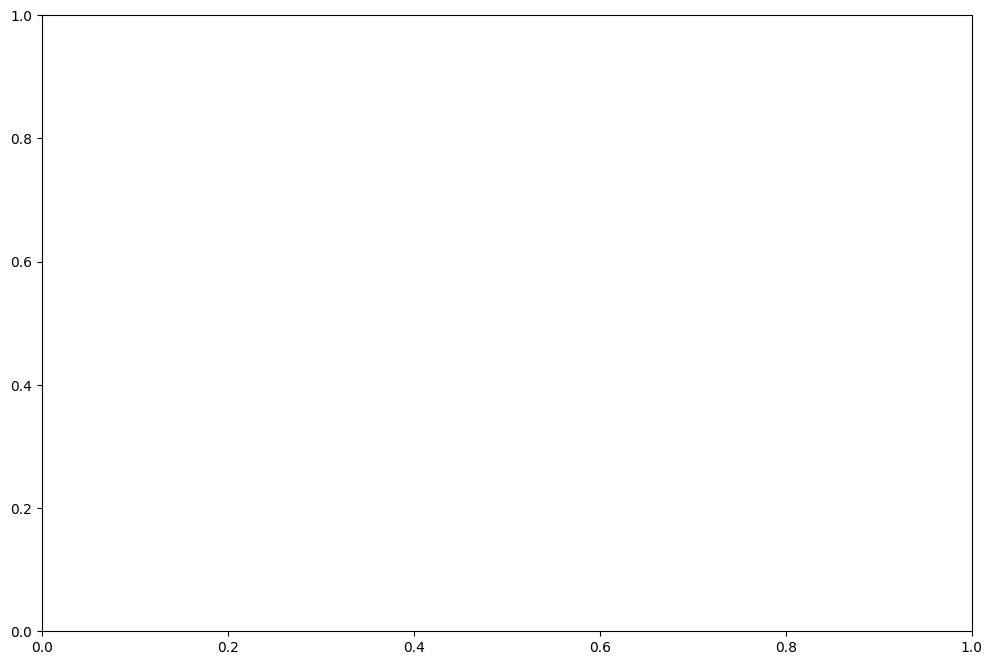

In [2]:
from cProfile import label

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for i in range(centers.shape[0]):
    ax.plot(centers[i, :], label=f'Cluster {i}')
sample = train_dtc.sample()
ax.plot(sample.iloc[:, 10:35].to_numpy()[0], label=f'Example clust: {sample.cluster.to_numpy()}')
ax.legend()
plt.show()

**Fit the distributions to an unnormalized gaussian function with 4 parameters (can be improved later)**

In [14]:
def func(x, a, b, c, u):
    return a * np.exp(-b * (x - u)**2) + c

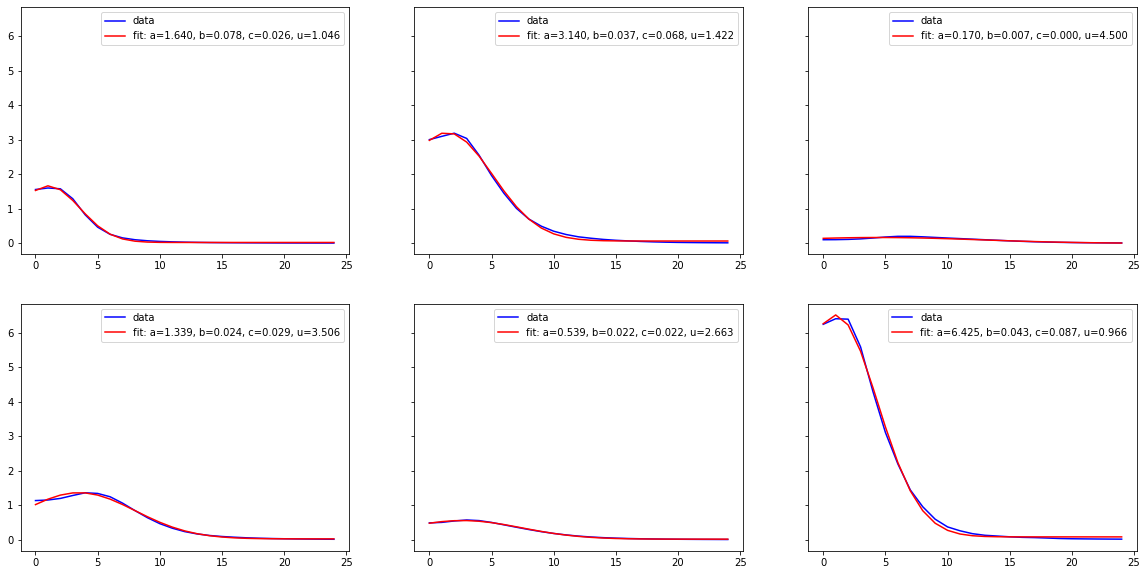

In [46]:
xdata = np.linspace(0, 24, 25)
bounds = ([-5.0, 0, 0, -1.0], [10.0, 5.0, 0.1, 4.5])

fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
for i in range(centers.shape[0]):
    ydata = centers[i, :]
    ax[i // 3, i % 3].plot(xdata, ydata, 'b-', label='data')

    popt, pcov = curve_fit(func, xdata, ydata, bounds=bounds)
    ax[i // 3, i % 3].plot(xdata, func(xdata, *popt), 'r-',
            label='fit: a=%5.3f, b=%5.3f, c=%5.3f, u=%5.3f' % tuple(popt))

    ax[i // 3, i % 3].legend()

Now that we have our distributions and our train-test split, lets train a neural net on 5 depths using our training set.

In [5]:
# gather our specific inputs / outputs
X_train_dtc = train_dtc[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
X_test_dtc = test_dtc[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
# outputs: depth_bin_0 (0-10m), depth_bin_3 (30-40m), depth_bin_6 (70-80m), depth_bin_9(90-100m)
label_bins = [0, 3, 6, 9]
Y_train_dtc = train_dtc[['depth_bin_' + str(i) for i in label_bins]]
Y_test_dtc = test_dtc[['depth_bin_' + str(i) for i in label_bins]]

input_dim = X_train_dtc.shape[1]
output_dim = Y_train_dtc.shape[1]

#scale the data
scaler = StandardScaler()
scaler.fit(X_train_dtc)
X_train_dtc = scaler.transform(X_train_dtc)
X_test_dtc = scaler.transform(X_test_dtc)

In [6]:
nn_model = Sequential()

nn_model.add(Dense(56, input_dim=input_dim, activation='relu'))
nn_model.add(Dropout(0.4))
nn_model.add(Dense(28, activation='relu'))
nn_model.add(Dropout(0.4))
nn_model.add(Dense(output_dim))

nn_model.compile(loss='mse', optimizer='adam')

nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                448       
                                                                 
 dropout (Dropout)           (None, 56)                0         
                                                                 
 dense_1 (Dense)             (None, 28)                1596      
                                                                 
 dropout_1 (Dropout)         (None, 28)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 116       
                                                                 
Total params: 2,160
Trainable params: 2,160
Non-trainable params: 0
_________________________________________________________________


In [7]:
# fit the model
nn_history = nn_model.fit(X_train_dtc, Y_train_dtc, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1188/1188 [==============================] - 13s 4ms/step - loss: 0.2559
Epoch 2/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1841
Epoch 3/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1778
Epoch 4/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1691
Epoch 5/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1662
Epoch 6/10
1188/1188 [==============================] - 4s 4ms/step - loss: 0.1674
Epoch 7/10
1188/1188 [==============================] - 4s 4ms/step - loss: 0.1621
Epoch 8/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1641
Epoch 9/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1566
Epoch 10/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1601


**Get predictions out of neural net**

In [8]:
preds = nn_model.predict(X_test_dtc)
actuals = Y_test_dtc.to_numpy()

210/210 [==============================] - 0s 1ms/step


**Interpolate predicted values and fit gaussian parameters**

In [15]:
def func(x, a, b, c, u):
    return a * np.exp(-b * (x - u)**2) + c

In [44]:
optimal_params = list()
xdata = np.linspace(0, 9, 4)
xnew = np.linspace(0, 9, 25)
bounds = ([-5.0, 0, 0, -1.0], [10.0, 5.0, 0.1, 4.5])
for p in preds[:30, :]:
    f = interp1d(xdata, p, kind='cubic')
    pinter = f(xnew)
    try:
        popt, pcov = curve_fit(func, xnew, pinter, bounds=bounds)
    except RuntimeError:
        continue
    optimal_params.append(popt)

**Plot full depth values with optimal params and save inter/exterpolated prediction values**

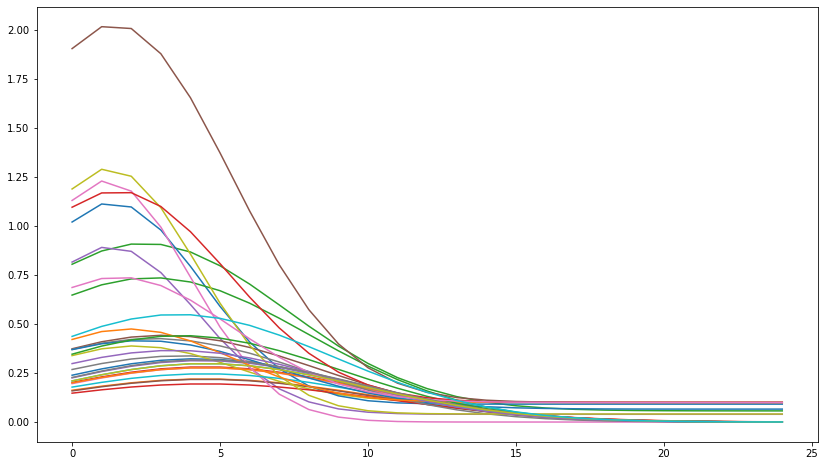

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
xlong = np.linspace(0, 24, 25)
ylong_preds = list()
for opt in optimal_params:
    ylong = func(xlong, *opt)
    ylong_preds.append(ylong)
    ax.plot(xlong, ylong)
plt.show()

ylong_preds = pd.DataFrame(np.array(ylong_preds)).rename({k:v for (k,v) in zip([i for i in range(25)], ['depth_bin_' + str(i) for i in range(25)])}, axis=1)

**Predict clusters using the above data and our kmeans model from earlier**

In [48]:
ylong_preds['cluster'] = kmeans.predict(ylong_preds)

In [27]:
## create a mixing function
def mix_vals(x1, x2, perc_x1=0.5):
    perc_x2 = 1-perc_x1
    return (x1*perc_x1) + (x2*perc_x2)

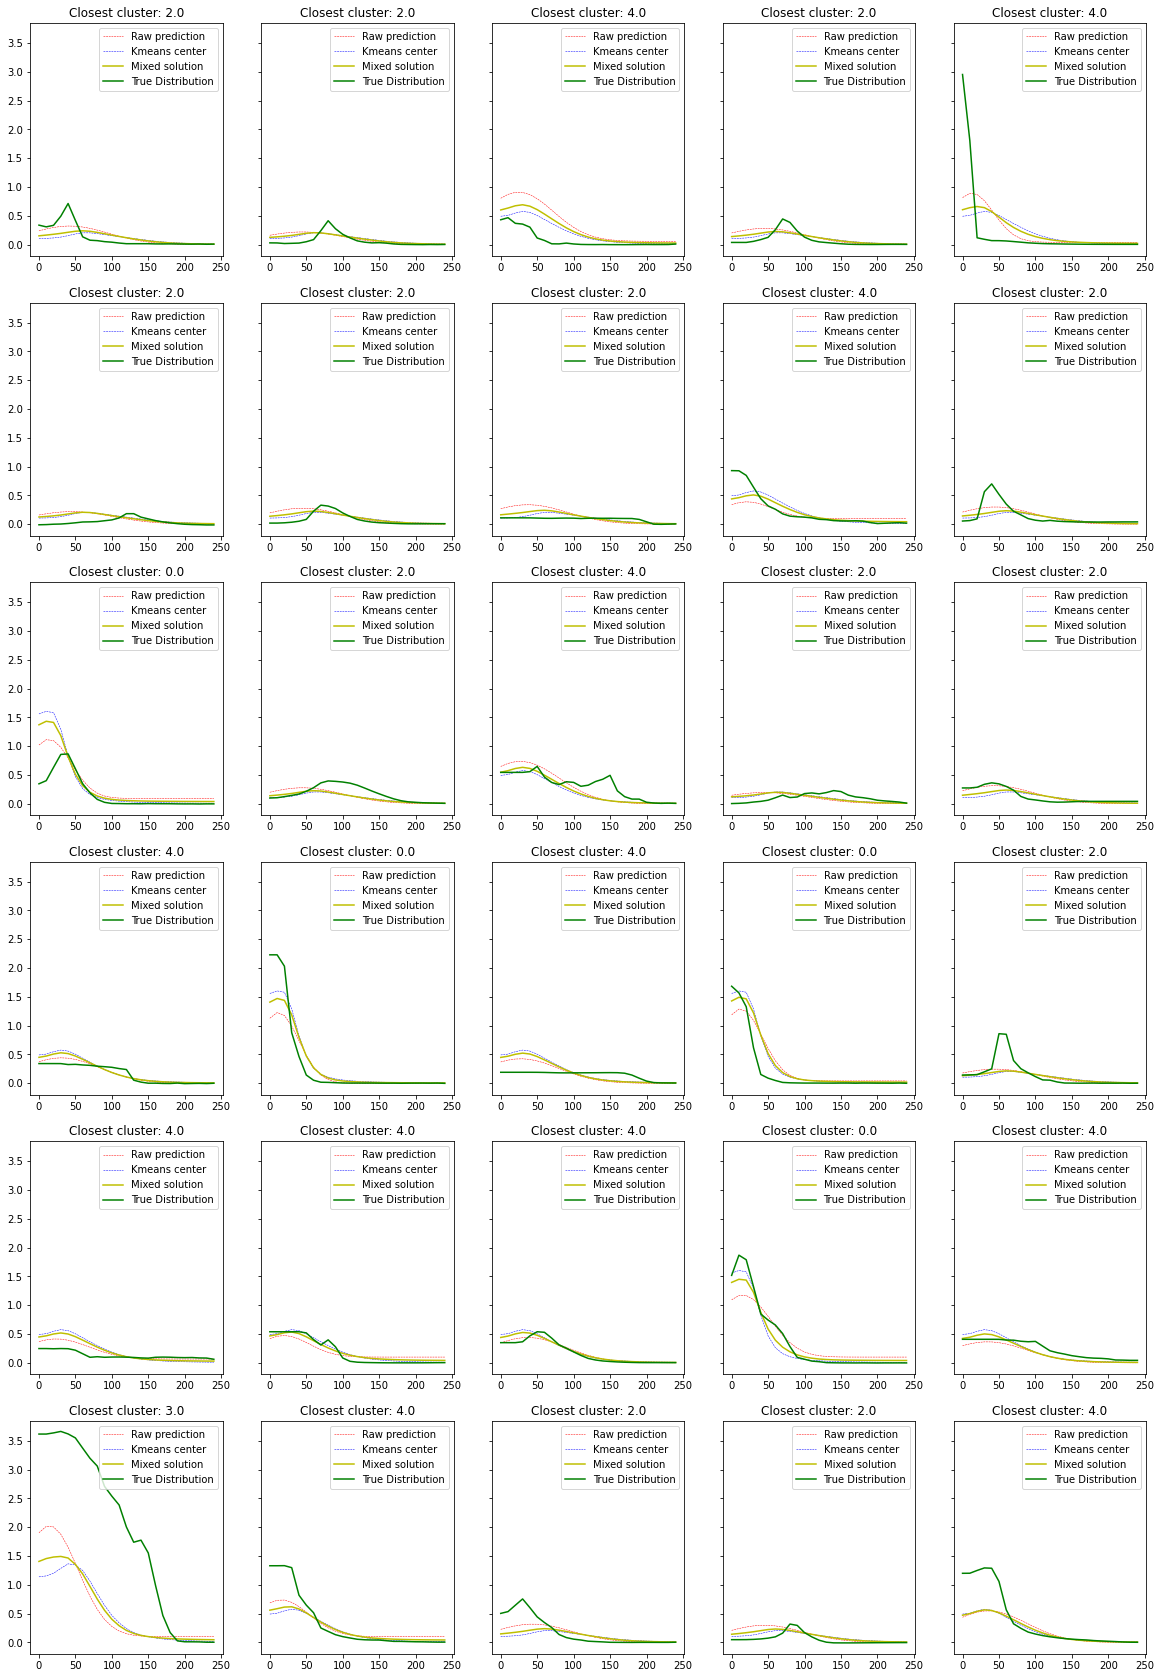

In [49]:
fig, ax = plt.subplots(6, 5, figsize=(20, 30), sharey=True)
for i, r in ylong_preds.iterrows():
    arow = i // 5
    acol = i % 5
    ax[arow, acol].plot(xlong*10, r.iloc[:-1], 'r--', linewidth=0.5, label='Raw prediction')
    ax[arow, acol].plot(xlong*10, centers[int(r.cluster), :], 'b--', linewidth=0.5, label='Kmeans center')
    ax[arow, acol].plot(xlong*10, mix_vals(centers[int(r.cluster), :], r.iloc[:-1].to_numpy(), perc_x1=0.65), 'y-', label='Mixed solution')
    ax[arow, acol].plot(xlong*10, test_dtc.iloc[i, 10:35].to_numpy(), 'g-', label='True Distribution')
    ax[arow, acol].set_title('Closest cluster: ' + str(r.cluster))
    ax[arow, acol].legend()
plt.show()